In [16]:
%%capture
## [TEMPLATE BEGIN]
## おまじない：実行中のノートブック名からOUTPUT_DIRを決めるコード
from pathlib import Path
from IPython import get_ipython; ip = get_ipython()
if '__vsc_ipynb_file__' in ip.user_ns:
    ## VS Codeで実行されている場合
    THIS_NOTEBOOK_PATH = Path(ip.user_ns['__vsc_ipynb_file__'])
else:
    !pip install ipynbname
    import ipynbname; THIS_NOTEBOOK_PATH = Path(ipynbname.path())
    if "%2F" in THIS_NOTEBOOK_PATH.stem:
        ## Google Colabで実行されている場合
        colab_ip = %system hostname -I   # uses colab magic to get list from bash
        colab_ip = colab_ip[0].strip()   # returns "172.28.0.12"
        colab_port = 9000                # could use 6000, 8080, or 9000
        import requests
        filename = requests.get(f"http://{colab_ip}:{colab_port}/api/sessions").json()[0]["name"]
        THIS_NOTEBOOK_PATH = Path(filename)
    else:
        ## それ以外の場合
        THIS_NOTEBOOK_PATH = THIS_NOTEBOOK_PATH

OUTPUT_DIR = Path("figures") / THIS_NOTEBOOK_PATH.stem
## [TEMPLATE END]

In [17]:
print("File output directory:", OUTPUT_DIR)
# Create the output directory if it does not exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

File output directory: figures/!_wine_decision_tree


In [18]:
!pip install networkx pydot


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


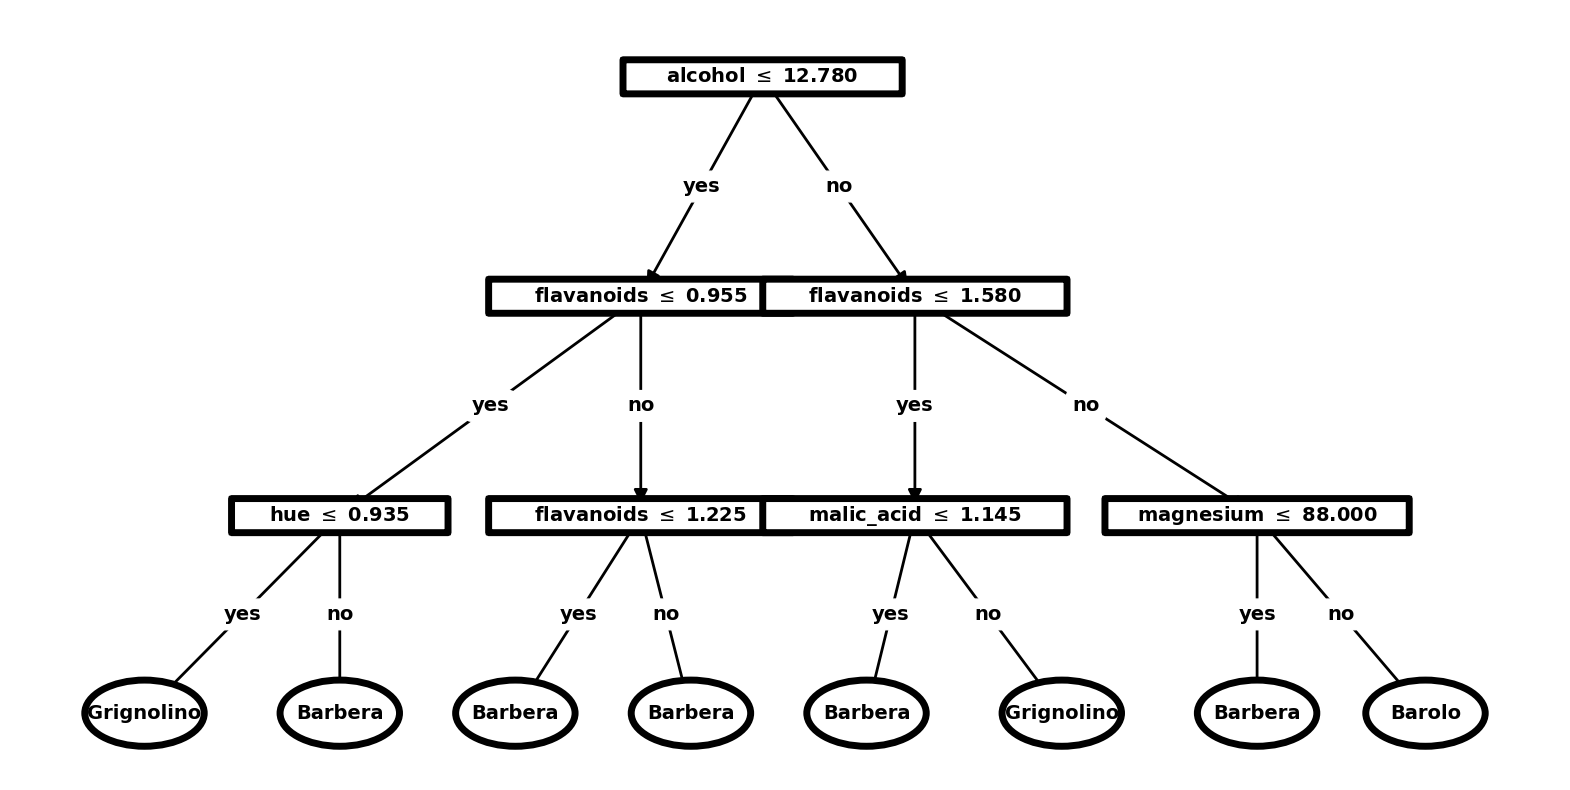

In [19]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.datasets import load_wine

# Set a random seed for reproducibility
RANDOM_STATE = 42

# Fetch the wine dataset from sklearn
data = load_wine(as_frame=True)
df = data.frame

# Select only the specified features
features = ['alcohol', 'malic_acid', 'magnesium', 'flavanoids', 'hue']
X = df[features]
y = df['target']
target_names = ['Barolo', 'Barbera', 'Grignolino']  # Custom class names

# Train decision tree classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
clf.fit(X, y)

# Extract tree information
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value = clf.tree_.value

# Initialize the graph
G = nx.DiGraph()

# Function to add nodes and edges to the graph
def add_node_edges(node, graph):
    if children_left[node] != children_right[node]:  # not a leaf node
        graph.add_node(node, label=f"{features[feature[node]]} <= {threshold[node]:.3f}".replace('<=', r'$\leq$'))
        graph.add_edge(node, children_left[node], label='yes')
        graph.add_edge(node, children_right[node], label='no')
        add_node_edges(children_left[node], graph)
        add_node_edges(children_right[node], graph)
    else:  # leaf node
        predicted_class = target_names[value[node].argmax()]
        graph.add_node(node, label=predicted_class)

# Start building the graph from the root node
add_node_edges(0, G)

# Extract the labels for nodes
labels = nx.get_node_attributes(G, 'label')

# Helper function to determine the width of the node based on its label and font size
def calculate_node_width(label, font_size=14, padding=10):
    char_width = font_size * 0.6  # Approximate width of a character
    return len(label) * char_width + padding

# Increase spacing by scaling positions
def scale_positions(pos, scale_x=1.2, scale_y=1.2):
    return {k: (v[0] * scale_x, v[1] * scale_y) for k, v in pos.items()}

# Draw the graph with customized nodes and edges, adjusting widths according to the string lengths and using bolder curves
plt.figure(figsize=(20, 10))

# Redefine the positions and scale them slightly for increased spacing
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
pos = scale_positions(pos, scale_x=1.2, scale_y=1.2)

# Draw edges with yes/no labels and arrows
edge_labels = {}
for node in G.nodes:
    for child in G.successors(node):
        if child == children_left[node]:
            edge_labels[(node, child)] = 'yes'
        else:
            edge_labels[(node, child)] = 'no'

nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='black', width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14, font_weight='bold', rotate=False)

# Draw labels with different shapes for leaf nodes
ax = plt.gca()
for node, (x, y) in pos.items():
    label = labels[node].replace('<=', r'$\leq$')
    width = calculate_node_width(label, font_size=14)
    if children_left[node] == children_right[node]:  # leaf node
        ax.add_patch(mpatches.Ellipse((x, y), 80, 40, edgecolor='black', facecolor='white', linewidth=5))  # Fixed size ellipses for leaf nodes with bold edges
    else:  # internal node
        ax.add_patch(mpatches.FancyBboxPatch((x - width / 2, y - 10), width, 20, boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', linewidth=5))
    ax.text(x, y, label, ha='center', va='center', fontsize=14, fontweight='bold')

plt.axis('off')
plt.savefig(OUTPUT_DIR / "wine_decision_tree_flow_chart.png", bbox_inches='tight', pad_inches=0)
plt.show()